# Analizamos los carriers

In [14]:
import sqlite3
import pandas as pd
import numpy as np                   # Para cosas de álgebra lineal
import matplotlib.pyplot as plt      # Para gráficos
import seaborn as sns                # Para gráficos lindos :^)
sns.set_style("darkgrid")
from sklearn import linear_model     # Para CML
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')
from utils import *

conn = sqlite3.connect('../vuelos.db')

# Cuales son los 5 carriers mas populares? (2003-2008)

In [15]:
df = query_db('''
select o.UniqueCarrier as Carrier, count(*) as cant
from ontime o
where o.year >= {yearfrom}
  and o.year <= {yearto}
  and o.year != 2001 and o.year != 2002
  group by UniqueCarrier
order by cant desc;
'''.format(yearfrom=2003, yearto=2008), conn)
for i in range(0,5):
    print(df.iloc[i]['Carrier'])
df = None

WN
AA
DL
OO
MQ


# Cuantos vuelos tiene cada carrier en cada mes? (2003-2008)

In [16]:
def cant_vuelos_carrier(carrier):
    return query_db('''
    select count(*) as cant, Month, Year
    from ontime o
    where o.year >= {yearfrom}
      and o.year <= {yearto}
      and o.year != 2001 and o.year != 2002
      and o.UniqueCarrier = '{carrier}'
      group by Month, Year
    order by Year asc, Month asc;
'''.format(yearfrom=2003, yearto=2008, carrier=carrier), conn)

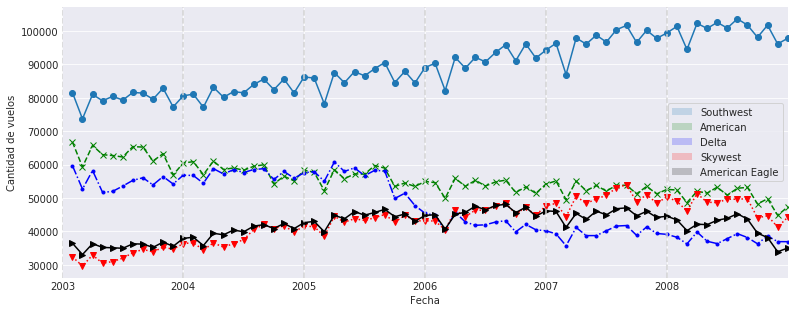

In [17]:
df_wn = cant_vuelos_carrier('WN')
df_aa = cant_vuelos_carrier('AA')
df_dl = cant_vuelos_carrier('DL')
df_oo = cant_vuelos_carrier('OO')
df_mq = cant_vuelos_carrier('MQ')

sns.set_style("darkgrid")
linestyles = ['--', '-.', ':', '-']
colors = ['green', 'blue', 'red', 'black']
markers = ['x', '.', 'v', '>']
df_wn['period'] = pd.Series([y*12+m for (y,m) in zip(df_wn['Year'], df_wn['Month'])])

plt.figure(figsize=(13, 5))

ax = sns.tsplot(time=df_wn['period'], marker='o', data=df_wn['cant'], interpolate=True)

for (frame, color, linestyle, marker) in zip([df_aa, df_dl, df_oo, df_mq], colors, linestyles, markers):
    frame['period'] = pd.Series([y*12+m for (y,m) in zip(df_wn['Year'], df_wn['Month'])])
    sns.tsplot(ax=ax, linestyle=linestyle, marker=marker, time=frame['period'], data=frame['cant'], interpolate=True, color=color)

ax.legend(['Southwest', 'American', 'Delta', 'Skywest', 'American Eagle'], frameon=True)
plt.xticks([i*12 for i in range(2003, 2009)], range(2003, 2009))
for i in range(2003,2009):
    plt.axvline(i*12, color='lightgray', linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vuelos')
plt.show()
df_wn = df_aa = df_dl = df_oo = df_mq = None

# Que le paso a delta en 2005?
Quebro en septiembre del 2005, fuente:
http://money.cnn.com/2005/09/14/news/fortune500/delta/
    
La gota que derramo el vaso fue el huracan katrina (ago 2005), que causo gran suba de precios en el petroleo
https://www.cfr.org/interview/katrina-and-oil-prices

# Que paso en marzo 2006?
# hablar de la mejoria de southwest

# Southwest airlines es el carrier con mas vuelos, por lejos. Que aeropuertos maneja?

In [18]:
df = query_db('''
    select Origin, Dest, Year, Month
    from ontime o
    where o.year >= {yearfrom}
      and o.year <= {yearto}
      and o.year != 2001 and o.year != 2002
      and o.UniqueCarrier = '{carrier}'
'''.format(yearfrom=2003, yearto=2008, carrier='WN'), conn)
df = None  # no se usa??

# Popularidad de aeropuertos de Origen de Southwest

In [19]:
df_origen = query_db('''
    select count(*) as cant, Origin, Dest, Year, Month
    from ontime o
    where o.year >= {yearfrom}
      and o.year <= {yearto}
      and o.year != 2001 and o.year != 2002
      and o.UniqueCarrier = '{carrier}'
      group by Origin
      order by cant desc
'''.format(yearfrom=2003, yearto=2008, carrier='WN'), conn)

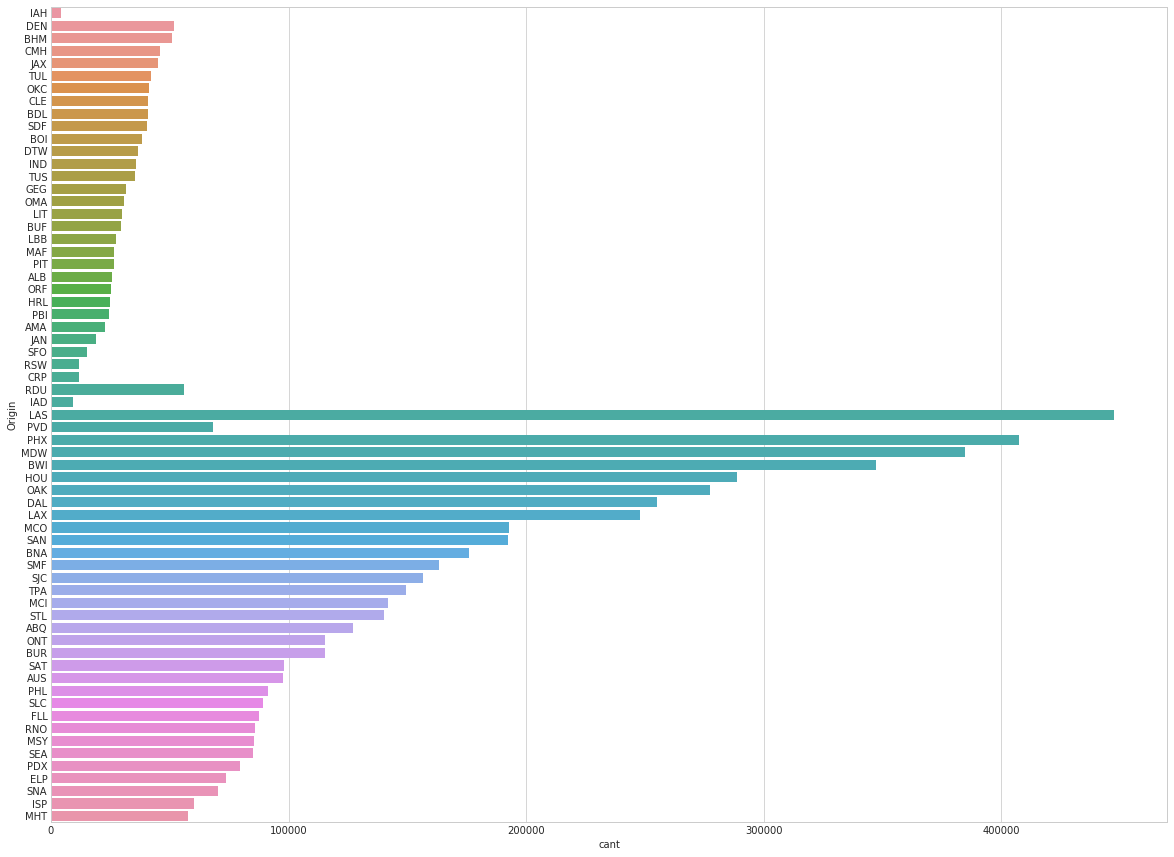

In [20]:
plt.figure(figsize=(20, 15))

df_origen = df_origen.sort_values(by=['Year']).reset_index(drop=True)
sns.set_style("whitegrid")
ax = sns.barplot(x="cant", y="Origin", data=df_origen)

plt.show();
df_origen = None

Los mas populares son: LAS,PHX, MDW, BWI y HOU

# Popularidad de aeropuertos de Destino de Southwest

In [21]:
df_dest = query_db('''
    select count(*) as cant, Origin, Dest, Year, Month
    from ontime o
    where o.year >= {yearfrom}
      and o.year <= {yearto}
      and o.year != 2001 and o.year != 2002
      and o.UniqueCarrier = '{carrier}'
      group by Dest
      order by cant desc
'''.format(yearfrom=2003, yearto=2008, carrier='WN'), conn)

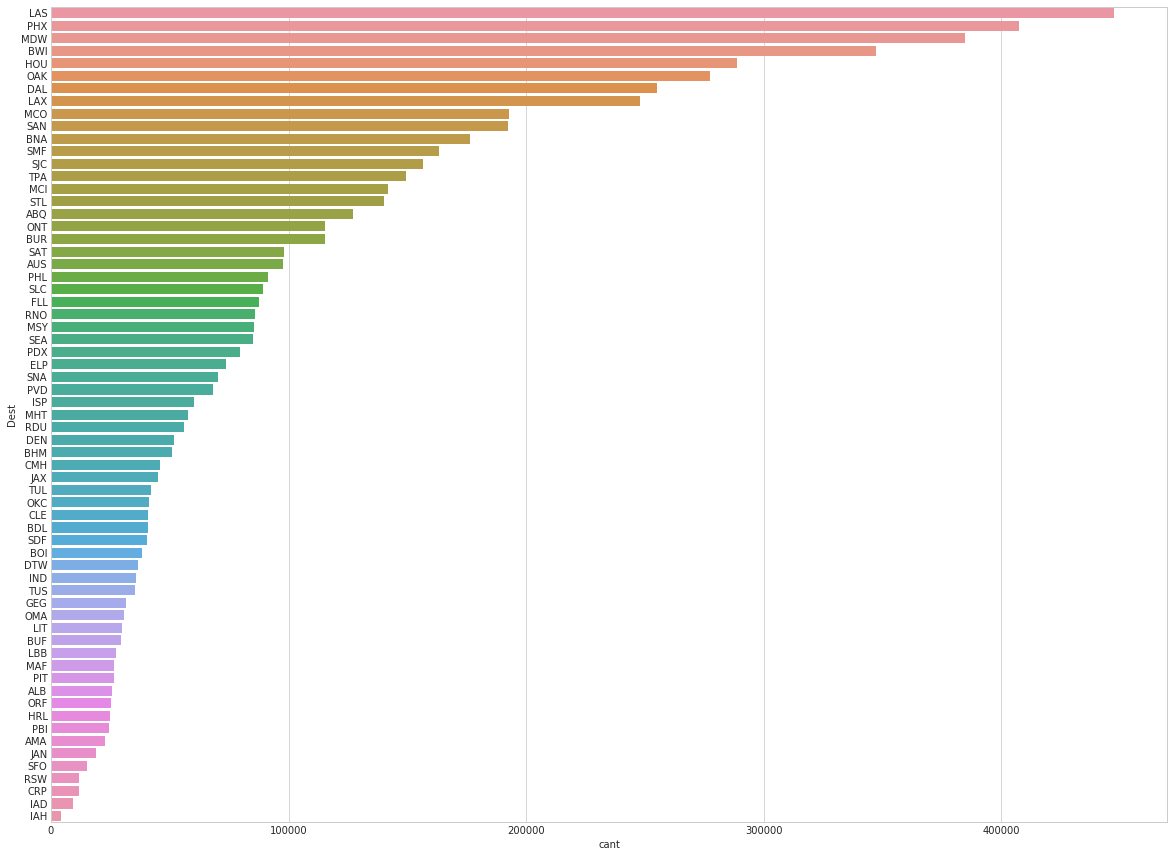

In [22]:
plt.figure(figsize=(20, 15))

df_dest = df_dest.sort_values(by=['cant']).reset_index(drop=True)
df_dest = df_dest.iloc[::-1]
sns.set_style("whitegrid")
ax = sns.barplot(x="cant", y="Dest", data=df_dest)

plt.show();
df_dest = None

Los mas populares siguen siendo: LAS, PHX, MDW, BWI y HOU

# Predicción

In [23]:
def plot_cant_vuelos(df, ax=None, color=None):
    df['period'] = pd.Series([y*12+m for (y,m) in zip(df['Year'], df['Month'])])
    #plt.figure(figsize=(20, 12))
    sns.set_style("darkgrid")
    plt.figure(figsize=(13, 5))
    ax = sns.tsplot(time=df['period'], color=color, marker='o', linestyle='--', data=df['cant'], interpolate=True, ax=ax)
    for i, year in enumerate(df['Year'].unique()):
        ax.axvline(year*12, color='lightgray', linestyle='--')
        #ax.text(i*12, 0.1, year)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Cantidad de vuelos')
    #ax.xaxis.set_label_coords(0.5, -0.05)
    #ax.tick_params(bottom='off', labelbottom='off')   # hide xticks    
    return ax

def armar_matriz_A(s, funcion):
    temp = []
    for t in s:
        temp.append(funcion(t))
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, funcion, x='x', y='y', ax=None, color=None):
    ax = plot_cant_vuelos(df, ax=ax, color=color)

    # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    regr = linear_model.LinearRegression(fit_intercept=False)

    ## Entreno el modelo
    
    # Armo la matriz A de features
    df_entrenamiento = df[df[x].isin(rango_entrenamiento)]
    A = armar_matriz_A(df_entrenamiento[x], funcion)
    
    # 'Fiteo' los datos de entrenamiento
    regr.fit(A, df_entrenamiento[y])
    
    # Grafico la aproximacion
    df_entrenamiento['pred'] = regr.predict(A)
    sns.tsplot(ax=ax, time=list(df_entrenamiento[x]), data=df_entrenamiento['pred'], value='Entrenamiento', color='red', linewidth=3)

    ## Realizo predicciones
    
    # Armo la matriz A de features
    df_prediccion = df[df[x].isin(rango_prediccion)]
    A = armar_matriz_A(df_prediccion[x], funcion)
    
    # Predigo los datos de testeo
    df_prediccion['pred'] = regr.predict(A)
    
    # Grafico la prediccion
    sns.tsplot(ax=ax, time=list(df_prediccion[x]), data=df_prediccion['pred'], value='Predicción', color='green', linewidth=3)

    ## Calculo el Error Cuadrático Medio
    ECM = sum((df_prediccion['pred'] - df_prediccion[y])**2) / df_prediccion.shape[0]
    
    # Restaura rango de X completo
    ax.set_xlim(df[x].iloc[0], df[x].iloc[-1])
     
    return ECM, ax

def predecir(carrier, start_at, train_months, test_months, func, ax=None, color=None):
    df = cant_vuelos_carrier(carrier)
    first_month = df['Year'].min() * 12
    rango_entrenamiento = list(range(first_month + start_at, first_month + start_at + train_months + 1))
    rango_prediccion = np.arange(first_month + start_at + train_months, first_month + start_at + train_months + test_months, 0.0625)
    
    print("Rango entrenamiento: {} .. {}".format(rango_entrenamiento[0], rango_entrenamiento[-1]))
    print("Rango predicción: {} .. {}".format(rango_prediccion[0], rango_prediccion[-1]))
    return entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion,
                                         func, ax=ax, x='period', y='cant', color=color)

## Predicción de WN

Rango entrenamiento: 24036 .. 24060
Rango predicción: 24060.0 .. 24071.9375
ECM: 8870643.389545428


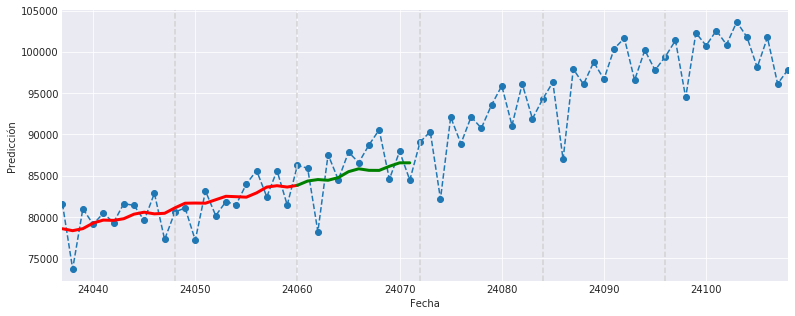

In [50]:
func = lambda t: [np.sin(0.82 * t), np.sin(1.5 * t), t**2, 1]
ecm, ax = predecir('WN', 0, 12*2, 12, func)


print("ECM: {}".format(ecm))
plt.show()

Rango entrenamiento: 24048 .. 24072
Rango predicción: 24072.0 .. 24083.9375
ECM: 9169579.89768116


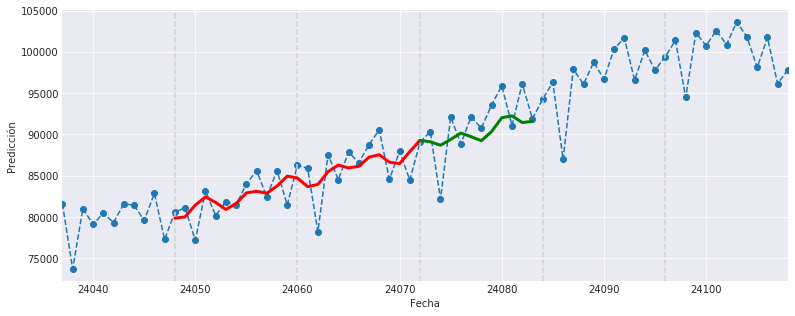

In [25]:
ecm, ax = predecir('WN', 12*1, 12*2, 12, func)

print("ECM: {}".format(ecm))
plt.show()

Rango entrenamiento: 24048 .. 24072
Rango predicción: 24072.0 .. 24083.9375
ECM: 2702611.2503818534


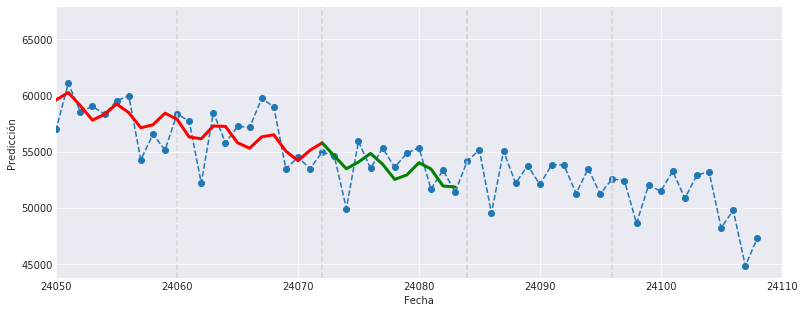

In [34]:
ecm, ax = predecir('AA', 12, 12*2, 12, func)

print("ECM: {}".format(ecm))
plt.xlim(24050, 24110)
plt.show()

Rango entrenamiento: 24048 .. 24072
Rango predicción: 24072.0 .. 24083.9375
ECM: 82051434.15115109


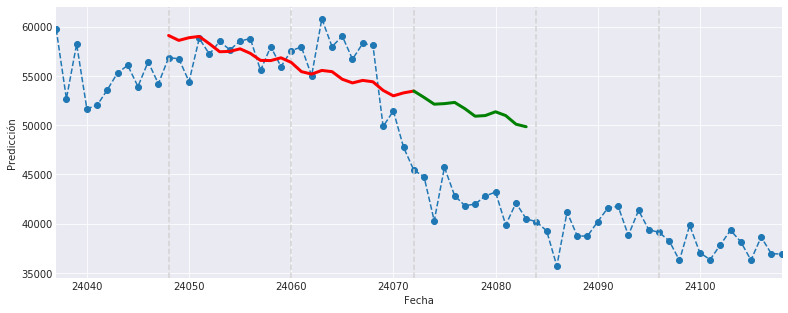

In [432]:
ecm, ax = predecir('DL', 12, 12*2, 12, func)

print("ECM: {}".format(ecm))
plt.show()

## Cross validation

### South west

Rango entrenamiento: 24048 .. 24060
Rango predicción: 24060.0 .. 24071.9375
Rango entrenamiento: 24048 .. 24072
Rango predicción: 24072.0 .. 24083.9375
Rango entrenamiento: 24048 .. 24084
Rango predicción: 24084.0 .. 24095.9375
Rango entrenamiento: 24048 .. 24096
Rango predicción: 24096.0 .. 24107.9375
ECM: 10880616.549664613


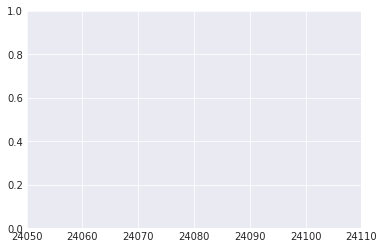

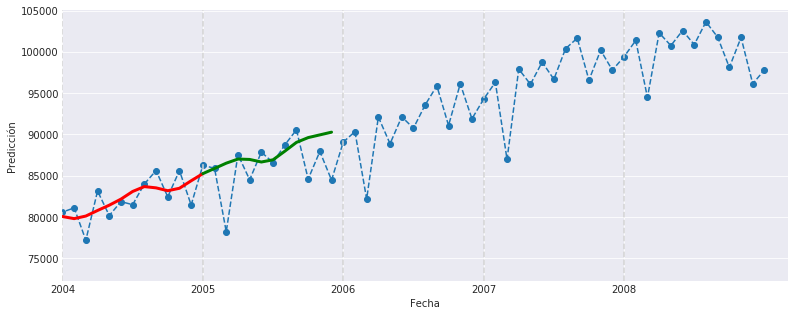

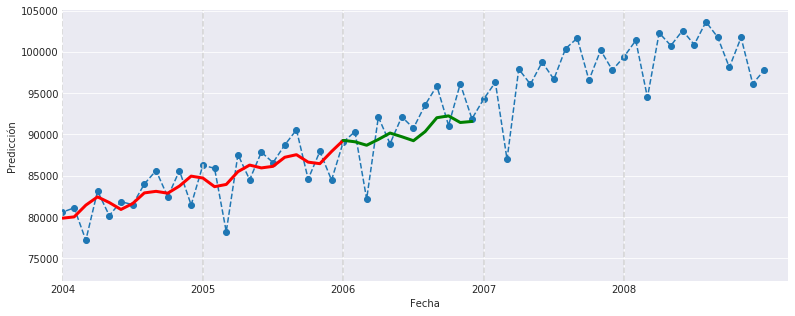

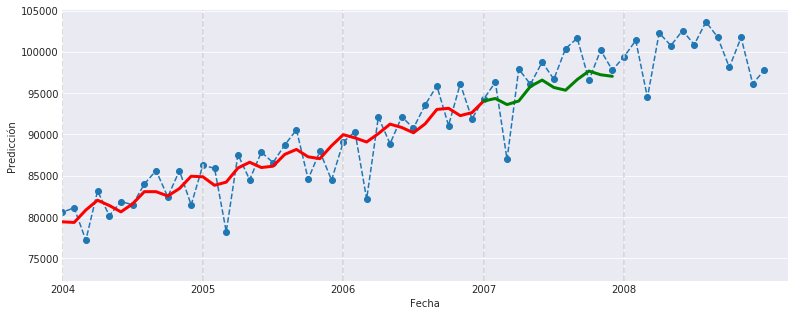

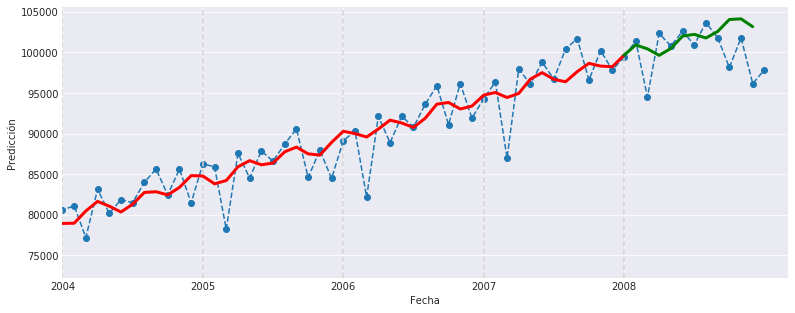

In [55]:
def crossval(carrier, color=None):
    func = lambda t: [np.sin(0.82 * t), np.sin(1.5 * t), t**2, 1]
    ecms = []
    ax = None
    for i in range(4):
        ecm, ax = predecir(carrier, 12, 12*(i+1), 12, func, ax=None, color=color)
        plt.xlim(24050, 24110)
        plt.xticks([j*12 for j in range(2004, 2009)], range(2004, 2009))
        ecms.append(ecm)
    ecms = np.array(ecms)
    return ecms

plt.xlim(24050, 24110)

ecms = crossval('WN')
print("ECM: {}".format(ecms.mean()))
plt.show()

# American Airlines

Rango entrenamiento: 24048 .. 24060
Rango predicción: 24060.0 .. 24071.9375
Rango entrenamiento: 24048 .. 24072
Rango predicción: 24072.0 .. 24083.9375
Rango entrenamiento: 24048 .. 24084
Rango predicción: 24084.0 .. 24095.9375
Rango entrenamiento: 24048 .. 24096
Rango predicción: 24096.0 .. 24107.9375
ECM: 5758333.867997553


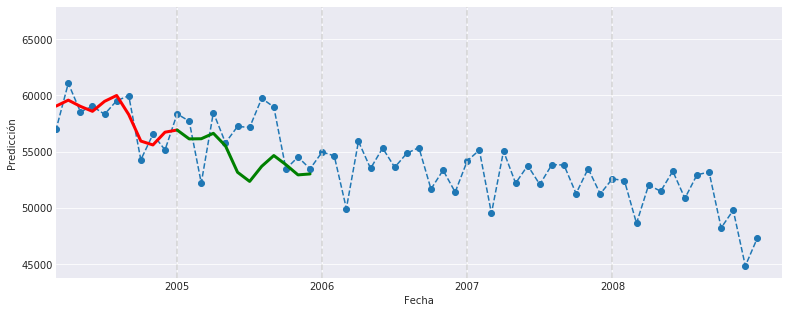

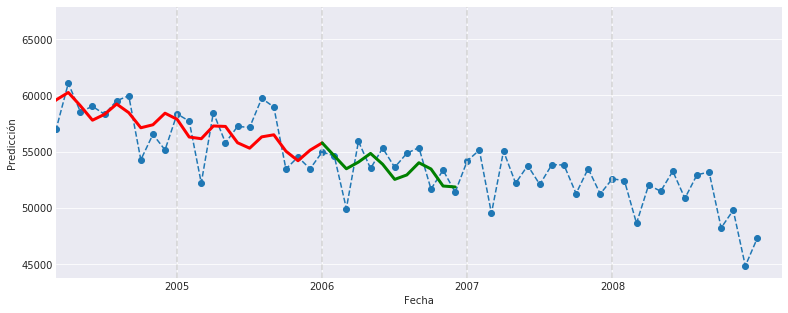

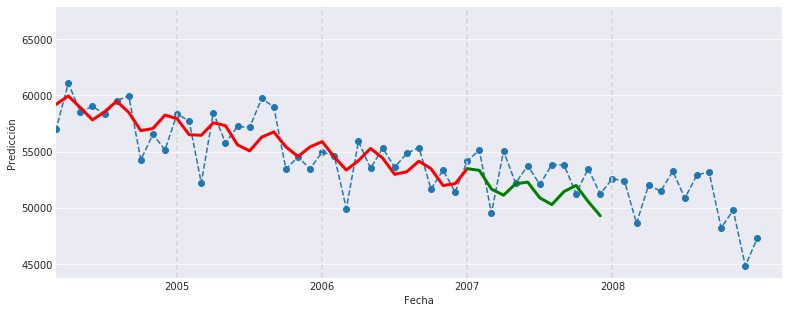

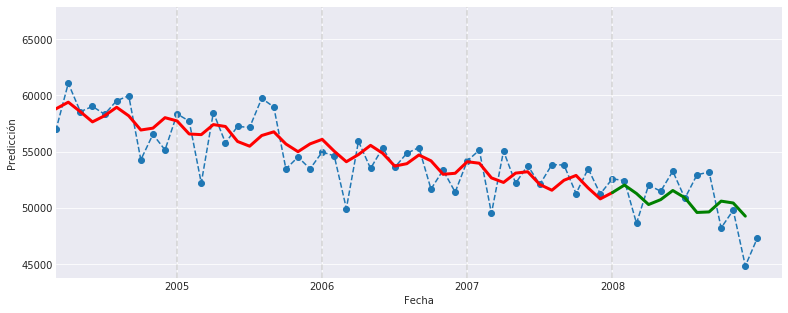

In [46]:
def crossval(carrier, color=None):
    func = lambda t: [np.sin(0.82 * t), np.sin(1.5 * t), t**2, 1]
    ecms = []
    ax = None
    for i in range(4):
        ecm, ax = predecir(carrier, 12, 12*(i+1), 12, func, ax=None, color=color)
        plt.xticks([j*12 for j in range(2004, 2009)], range(2004, 2009))
        plt.xlim(24050, 24110)
        ecms.append(ecm)
    ecms = np.array(ecms)
    return ecms

ecms = crossval('AA')
print("ECM: {}".format(ecms.mean()))
plt.show()

### Delta (caso malo)

Rango entrenamiento: 24048 .. 24060
Rango predicción: 24060.0 .. 24071.9375
Rango entrenamiento: 24048 .. 24072
Rango predicción: 24072.0 .. 24083.9375
Rango entrenamiento: 24048 .. 24084
Rango predicción: 24084.0 .. 24095.9375
Rango entrenamiento: 24048 .. 24096
Rango predicción: 24096.0 .. 24107.9375
ECM: 35712035.64123726


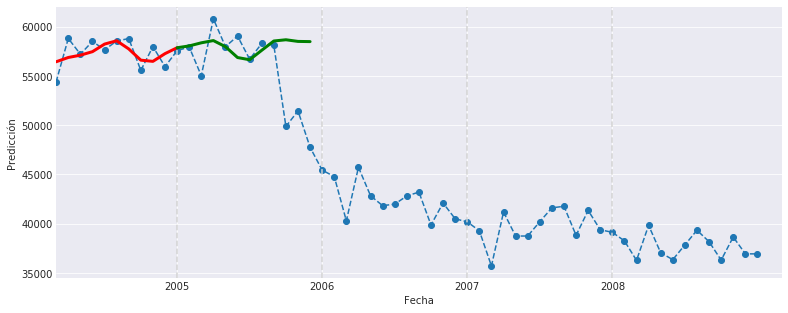

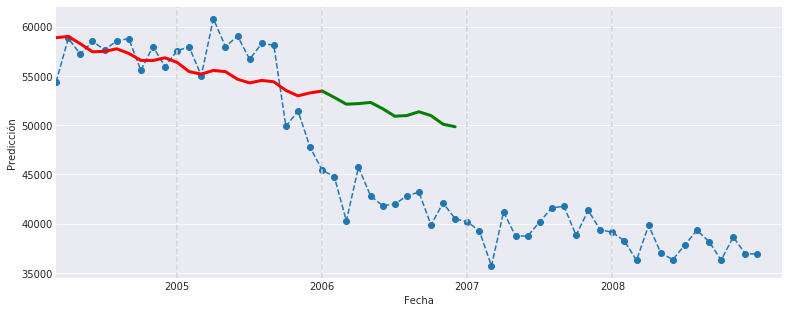

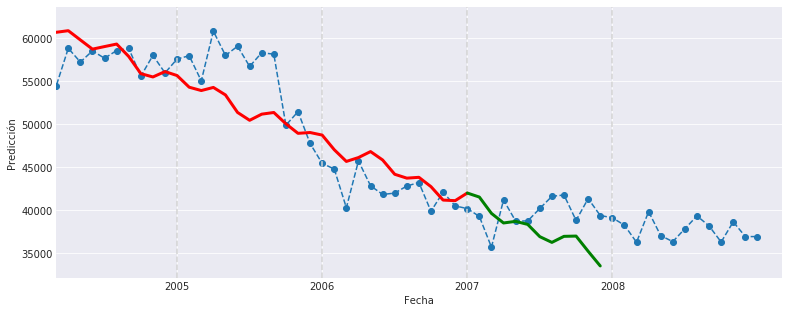

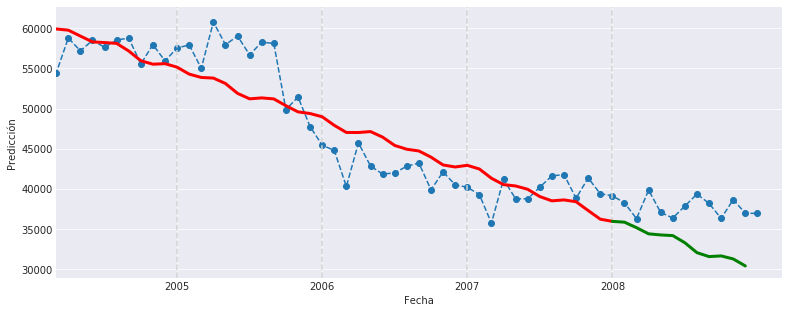

In [47]:
ecms = crossval('DL')
print("ECM: {}".format(ecms.mean()))
plt.show()